In [6]:
# Load the data set employees_aatrition_dataset_10000.csv into a pandas dataframe
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# Load the data set
train = pd.read_csv('train.csv')

### Transform the data to only numerical values

In [7]:
# Binary mapping
binary_map = {
    "Gender": {"Male": 0, "Female": 1},
    "OverTime": {"No": 0, "Yes": 1},
    "Over18": {"N": 0, "Y": 1}
}

for col, mapping in binary_map.items():
    if col in train.columns:
        train[col] = train[col].map(mapping)

# One-hot encoding for multi-class categorical columns
categorical_cols = ["BusinessTravel", "Department", "EducationField", "JobRole", "MaritalStatus"]
train = pd.get_dummies(train, columns=categorical_cols)
# Convert all boolean (True/False) columns to integers (0/1)
train = train.astype({col: int for col in train.select_dtypes(include='bool').columns})


In [8]:
# save the data set to a csv file
train.to_csv('train_processed.csv', index=False)

# Print the first 5 rows of the data set
print(train.head())
# Print the shape of the data set
print(train.shape)


   Age  Attrition  DailyRate  DistanceFromHome  Education  EmployeeCount  \
0   41          1       1102                 1          2              1   
1   49          0        279                 8          1              1   
2   37          1       1373                 2          2              1   
3   33          0       1392                 3          4              1   
4   27          0        591                 2          1              1   

   EmployeeNumber  EnvironmentSatisfaction  Gender  HourlyRate  ...  \
0               1                        2       1          94  ...   
1               2                        3       0          61  ...   
2               4                        4       0          92  ...   
3               5                        4       1          56  ...   
4               7                        1       0          40  ...   

   JobRole_Laboratory Technician  JobRole_Manager  \
0                              0                0   
1         

In [9]:
# Basic Summary Statistics
print(train.describe())

               Age    Attrition    DailyRate  DistanceFromHome    Education  \
count  1058.000000  1058.000000  1058.000000       1058.000000  1058.000000   
mean     37.055766     0.169187   809.542533          8.978261     2.879017   
std       9.410421     0.375094   408.478049          8.040608     1.031442   
min      18.000000     0.000000   102.000000          1.000000     1.000000   
25%      30.000000     0.000000   465.250000          2.000000     2.000000   
50%      36.000000     0.000000   817.500000          7.000000     3.000000   
75%      43.000000     0.000000  1168.500000         13.000000     4.000000   
max      60.000000     1.000000  1499.000000         29.000000     5.000000   

       EmployeeCount  EmployeeNumber  EnvironmentSatisfaction       Gender  \
count         1058.0     1058.000000              1058.000000  1058.000000   
mean             1.0      731.753308                 2.712665     0.413989   
std              0.0      431.418209                 1

### Correlation 

In [10]:
def show_high_correlations(train, threshold):
    corr_matrix = train.corr().abs()  # absolute value of correlations
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # upper triangle only

    # Find index pairs with correlation above threshold
    high_corr = upper.stack()[upper.stack() > threshold].sort_values(ascending=False)

    if not high_corr.empty:
        print("Highly correlated feature pairs (>|{:.2f}|):\n".format(threshold))
        for (feat1, feat2), corr_val in high_corr.items():
            print(f"{feat1} ↔ {feat2} : correlation = {corr_val:.3f}")
    else:
        print(f"No feature pairs with correlation above {threshold}.")

# Example usage:
show_high_correlations(train, threshold=0.6)


Highly correlated feature pairs (>|0.60|):

JobLevel ↔ MonthlyIncome : correlation = 0.954
Department_Research & Development ↔ Department_Sales : correlation = 0.921
Department_Human Resources ↔ JobRole_Human Resources : correlation = 0.885
Department_Sales ↔ JobRole_Sales Executive : correlation = 0.807
JobLevel ↔ TotalWorkingYears : correlation = 0.787
MonthlyIncome ↔ TotalWorkingYears : correlation = 0.778
PercentSalaryHike ↔ PerformanceRating : correlation = 0.770
YearsAtCompany ↔ YearsInCurrentRole : correlation = 0.763
YearsAtCompany ↔ YearsWithCurrManager : correlation = 0.762
BusinessTravel_Travel_Frequently ↔ BusinessTravel_Travel_Rarely : correlation = 0.758
Department_Research & Development ↔ JobRole_Sales Executive : correlation = 0.743
YearsInCurrentRole ↔ YearsWithCurrManager : correlation = 0.722
Age ↔ TotalWorkingYears : correlation = 0.690
StockOptionLevel ↔ MaritalStatus_Single : correlation = 0.643
TotalWorkingYears ↔ YearsAtCompany : correlation = 0.627
MaritalStatu

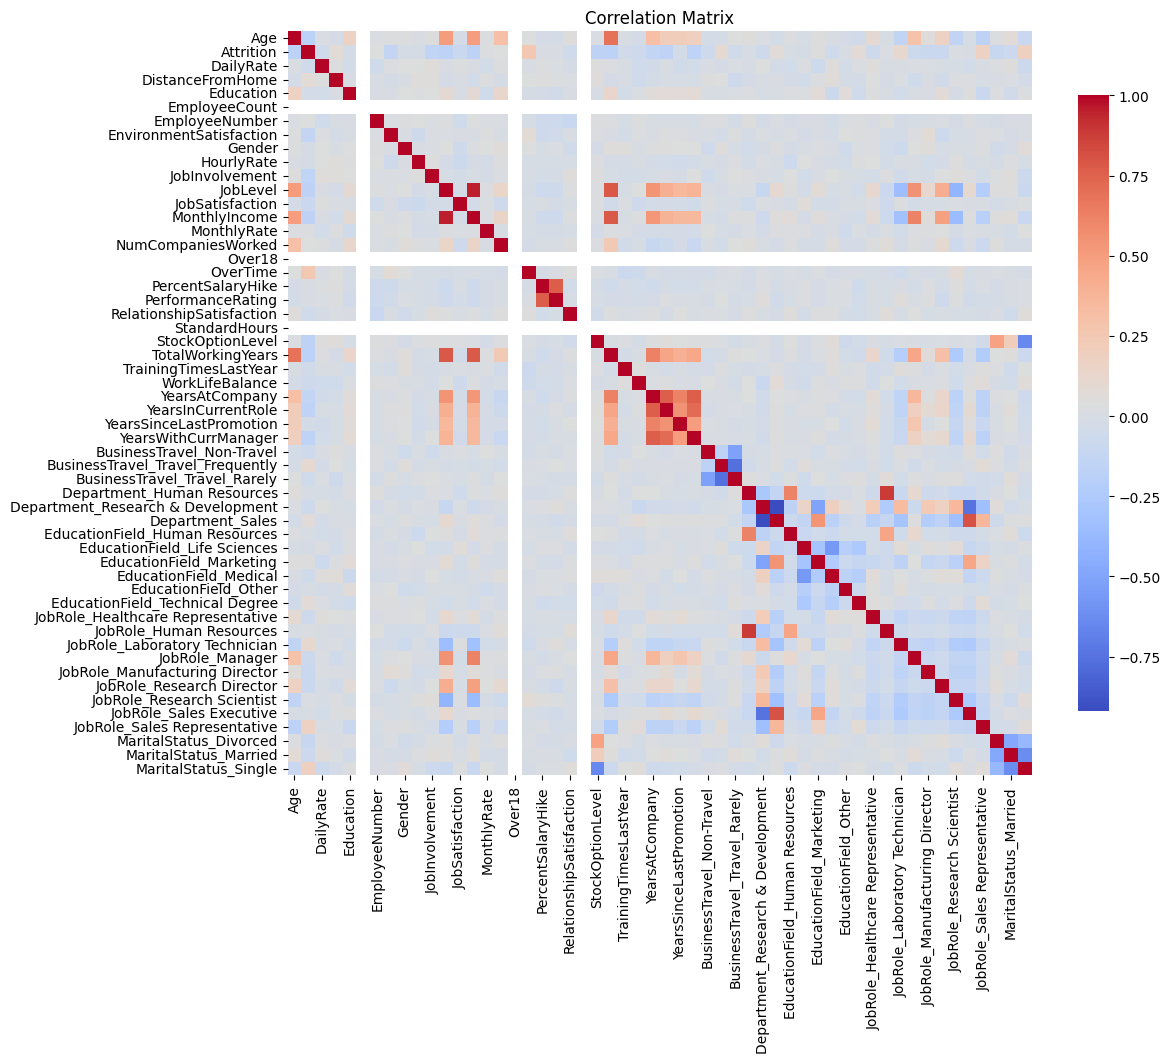

In [11]:
# Make a correlation matrix and print save it to a file
def plot_correlation_matrix(data):
    # Calculate the correlation matrix
    corr = train.corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 10))
    # Draw the heatmap without annotations
    sns.heatmap(corr, cmap='coolwarm', annot=False, square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix')
    plt.savefig('correlation_matrix.png')
    plt.show()
# Plot the correlation matrix
plot_correlation_matrix(train)

### Distribution of the target value

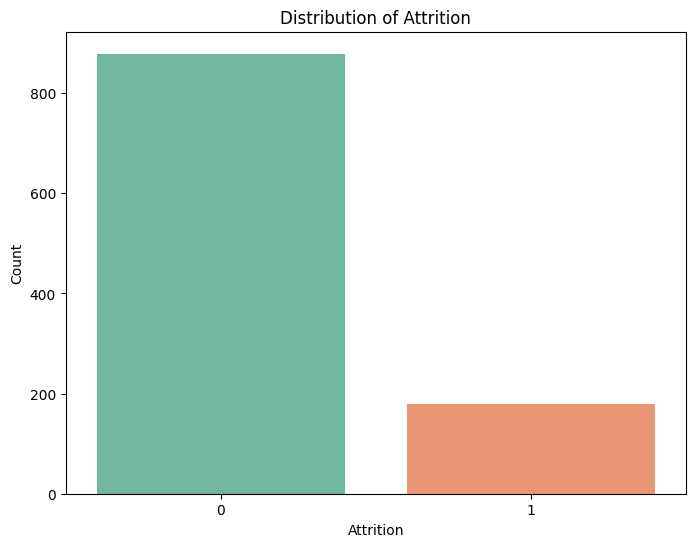

In [12]:
# Plot the distribution of the target variable
def plot_target_distribution(train):
    plt.figure(figsize=(8, 6))
    sns.countplot(x='Attrition', data=train, palette='Set2')
    plt.title('Distribution of Attrition')
    plt.xlabel('Attrition')
    plt.ylabel('Count')
    plt.savefig('target_distribution.png')
    plt.show()
# Plot the target distribution
plot_target_distribution(train)

In [13]:
train["Attrition"].value_counts(normalize=True)

Attrition
0    0.830813
1    0.169187
Name: proportion, dtype: float64

### Group-wise analysis

Understand how the target depends on features

This will guide edge creation in your PGM

In [14]:
# Understand how the target depends on features
train.groupby("Age")["Attrition"].mean()

Age
18    0.500000
19    0.666667
20    0.666667
21    0.500000
22    0.250000
23    0.142857
24    0.294118
25    0.272727
26    0.366667
27    0.055556
28    0.294118
29    0.272727
30    0.125000
31    0.285714
32    0.166667
33    0.261905
34    0.111111
35    0.096154
36    0.106383
37    0.121951
38    0.027027
39    0.240000
40    0.078947
41    0.200000
42    0.058824
43    0.043478
44    0.208333
45    0.068966
46    0.086957
47    0.142857
48    0.076923
49    0.133333
50    0.125000
51    0.111111
52    0.176471
53    0.000000
54    0.000000
55    0.187500
56    0.100000
57    0.000000
58    0.454545
59    0.000000
60    0.000000
Name: Attrition, dtype: float64

### Chi-Square Tests for Categorical Features
Check dependence between two categorical variables

If p-value is small → likely dependency → draw an edge in your PGM.

In [15]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(train["Gender"], train["YearsAtCompany"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"p-value = {p:.4f}")


p-value = 0.4985


In [16]:
contingency = pd.crosstab(train["Age"], train["YearsAtCompany"])
chi2, p, _, _ = chi2_contingency(contingency)
print(f"p-value = {p:.4f}")

p-value = 0.0000


### Mutual Information (Info-Theoretic Dependency)

For non-linear dependencies (numeric ↔ categorical)

This helps determine which features are informative for predicting attrition, even if not linearly correlated

In [17]:
from sklearn.feature_selection import mutual_info_classif

X = train.drop("Attrition", axis=1)
y = train["Attrition"]
mi = mutual_info_classif(X, y)

In [18]:
print(mi)

[0.03496398 0.         0.         0.         0.02301041 0.00406965
 0.00831123 0.         0.         0.00507095 0.01221647 0.00506693
 0.02224419 0.01183809 0.01933046 0.00507417 0.00603653 0.00919588
 0.         0.00517445 0.         0.02239987 0.01123416 0.01194318
 0.         0.02142668 0.02835138 0.01111768 0.03161254 0.00566919
 0.00515439 0.         0.         0.00745764 0.01728709 0.
 0.01458863 0.00448008 0.0051444  0.         0.00199863 0.00314167
 0.00165462 0.02568359 0.03279389 0.03296438 0.00649807 0.
 0.00726198 0.02269853 0.0088414  0.00582439 0.00525414]
